In [1]:
"""
Vehicle-focused fingerprints
Track-focused fingerprints
Adaptable window length
Encoding fingerprint statistics into an overall fingerprint for a longer segment

"""



import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import signal
from scipy.signal import get_window
from matplotlib.ticker import AutoMinorLocator
from dataclasses import dataclass

import shazam_rail as sr

# This is for jupyter to recognize changes in external files without restarting kernel
%load_ext autoreload
%autoreload 2

In [2]:
plt.rcParams.update({
    "font.size": 12,
    "axes.labelsize": 14,
    "axes.titlesize": 15,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.dpi": 120
})

## Workflow
### 1. Load data

In [3]:
# Inputs
path = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\01 Simulations\main_model\output"
scenario = "S7_IRREG1_K1"
sensor_locations = ["SRS_CB_B1", "SRS_CB_cab", "SRS_B1_R", "SRS_B1_WS1_R"]
sensor_names = ["carbody_B1", "carbody_cab", "B1_right", "WS1_right"]

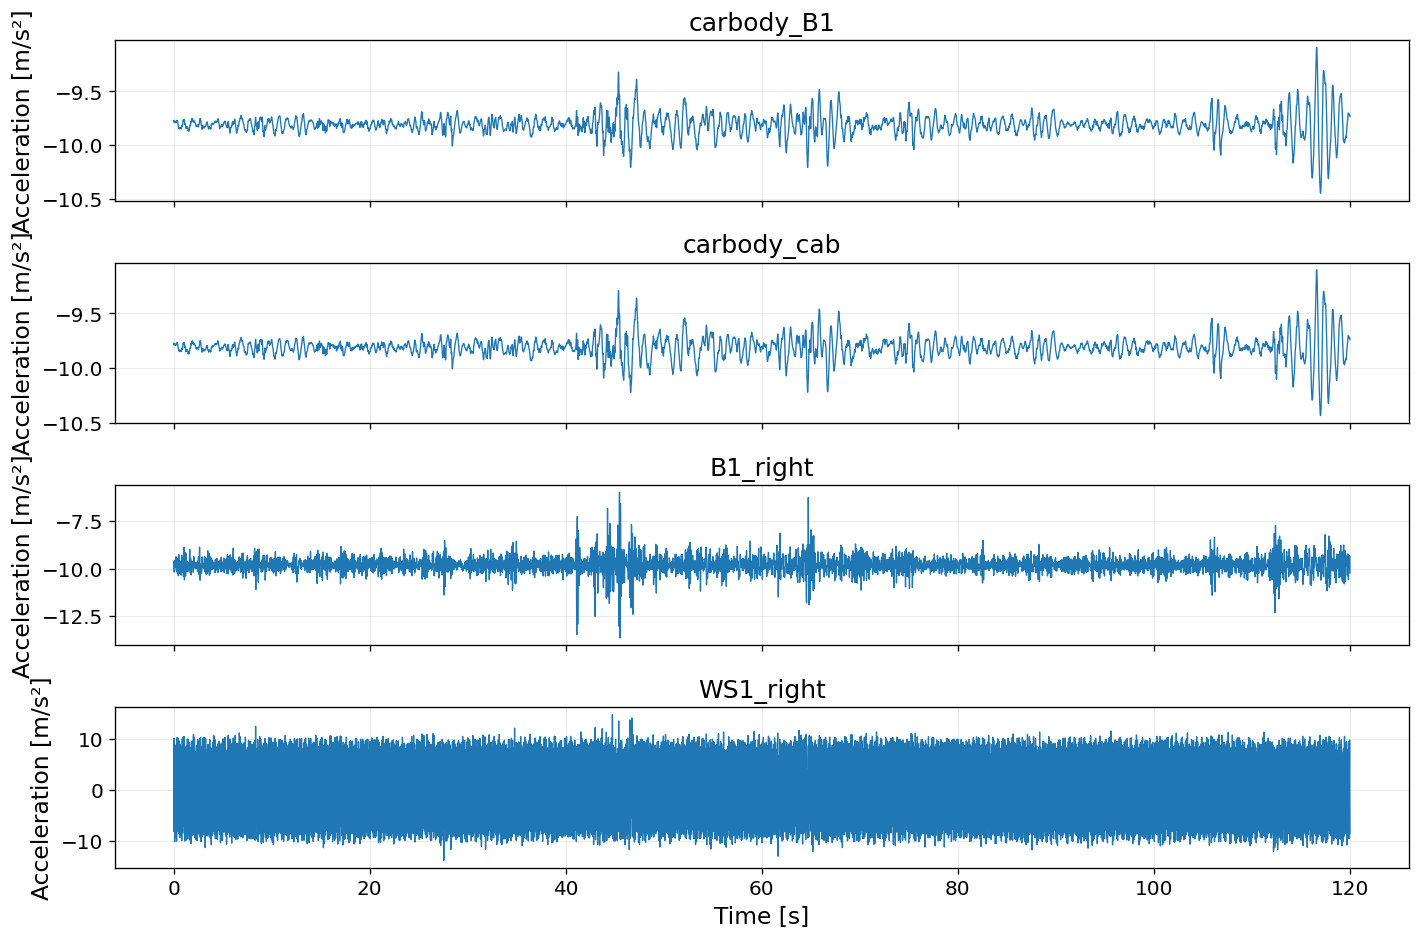

In [17]:
sensor_data = sr.load_data(path, scenario)

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 8), sharex=True)

for ax, sensor_name in zip(axes, sensor_names):
    acceleration, time, _ = sensor_data[sensor_name]
    ax.plot(time, acceleration, linewidth=0.8)
    ax.set_ylabel("Acceleration [m/s²]")
    ax.set_title(sensor_name)
    ax.grid(True, linewidth=0.3, alpha=0.5)

axes[-1].set_xlabel("Time [s]")

plt.tight_layout()
plt.show()

### 2. STFT

In [27]:
fs = 50  # Hz, simulation sampling freq
window_length = 4  # seconds
window_type = 'hann'
overlap = 0.9
fft_size = 256

stft_results, freqs, sensor_data_detrended = sr.stft(sensor_data, fs=fs, window_length = window_length, window_type = window_type, overlap = overlap, fft_size = fft_size)


Number of samples in a window: 200
Stride: 19
Number of samples overlapping per window: 181


Number of frequencies: 129
Number of time windows: 317
Frequency resolution: 0.1953125


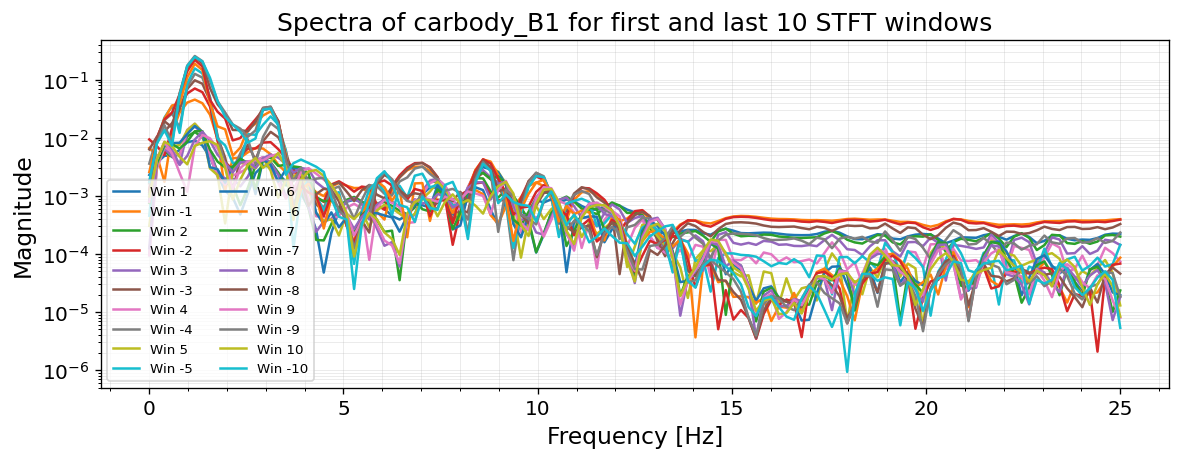

New length: 117.8 seconds
New number of time windows: 305


In [28]:
###############
### TESTING ###
###############

stft_magnitude_test = stft_results[sensor_names[0]]["stft_magnitude"]
Zxx_test = stft_results[sensor_names[0]]["Zxx"]
f_test = stft_results[sensor_names[0]]["f"]

print(f'Number of frequencies: {Zxx_test.shape[0]}')
print(f'Number of time windows: {Zxx_test.shape[1]}')
print(f'Frequency resolution: {fs/fft_size}')

"""
NOTES

Zxx[:, k] is the complex spectrum of the k-th time window
Zxx[f, :] is the time evolution of one frequency bin
stft_magnitude[:, k] is the magnitude spectrum of window k
"""
n_windows_to_plot = 10

plt.figure(figsize=(10, 4))

for k in range(n_windows_to_plot):
    spectrum_complex_first = Zxx_test[:, k]
    spectrum_complex_last = Zxx_test[:, -k-1]
    spectrum_magnitude_first = np.abs(spectrum_complex_first)
    spectrum_magnitude_last = np.abs(spectrum_complex_last)

    plt.semilogy(f_test, spectrum_magnitude_first, label=f"Win {k+1}")
    plt.semilogy(f_test, spectrum_magnitude_last, label=f"Win {-k-1}")

plt.xlabel("Frequency [Hz]")
plt.ylabel("Magnitude")
plt.title(f"Spectra of {sensor_names[0]} for first and last {n_windows_to_plot} STFT windows")

ax = plt.gca()
ax.xaxis.set_minor_locator(AutoMinorLocator(5))

plt.grid(True, which="both", linewidth=0.3, alpha=0.5)
plt.legend(fontsize=8, ncol=2)
plt.tight_layout()
plt.show()

"""
NOTES

This plot shows the STFT edge effect: the first and last frames include partial windows with zero padding that inflates high-frequency content due to signal truncation and the window’s spectral sidelobes spreading energy across frequency bins
A good solution is to discard the first and last 6 windows (we still have 305 windows left per simulation to work with)
"""
n_discard = 6

for sensor_name, stft_data in stft_results.items():
    Zxx = stft_data["Zxx"]
    t = stft_data["t"]

    Zxx_trim = Zxx[:, n_discard:-n_discard]
    t_trim = t[n_discard:-n_discard]
    stft_magnitude_trim = np.abs(Zxx_trim)

    stft_results[sensor_name]["Zxx"] = Zxx_trim
    stft_results[sensor_name]["t"] = t_trim
    stft_results[sensor_name]["stft_magnitude"] = stft_magnitude_trim

print(f'New length: {stft_results[sensor_names[0]]["t"][-1]} seconds')
print(f'New number of time windows: {stft_results[sensor_names[0]]["Zxx"].shape[1]}')

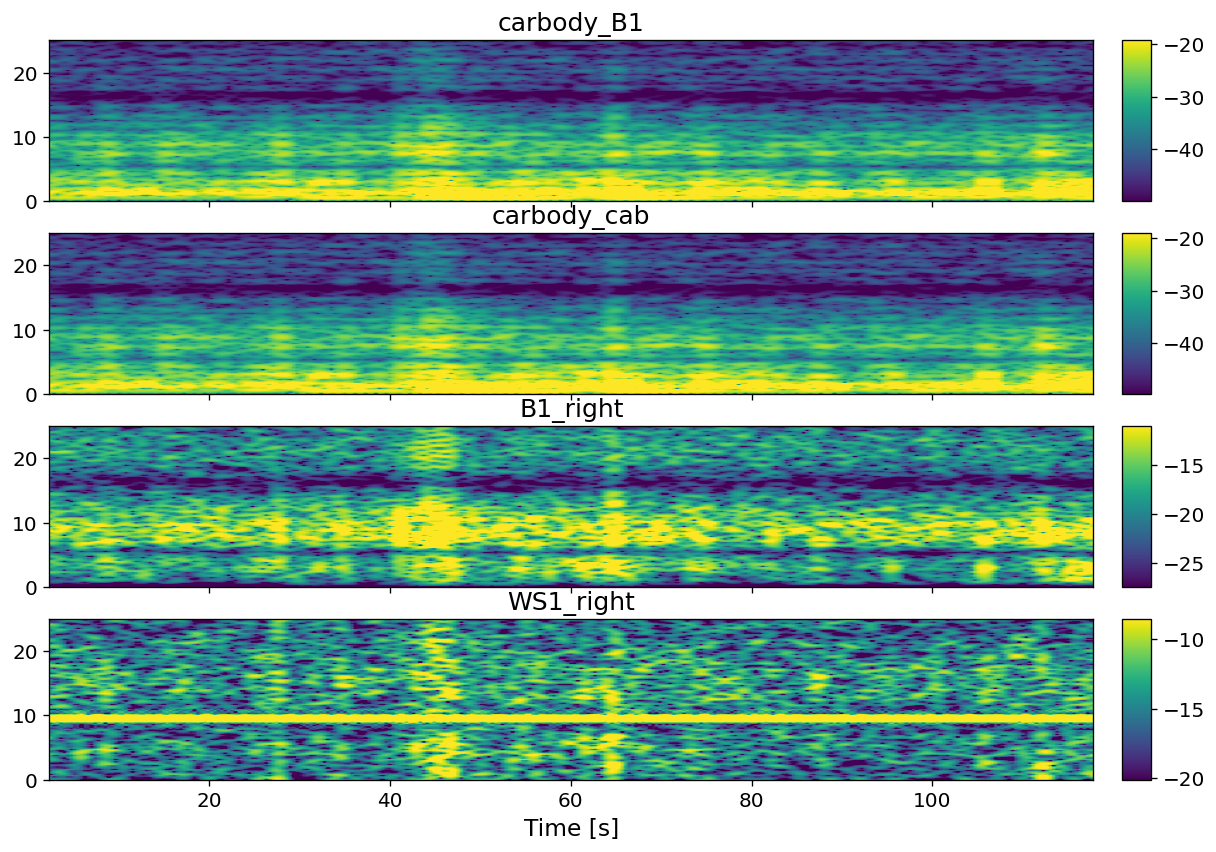

In [29]:
# visualization of spectrogram

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 8), sharex=True, gridspec_kw={'right':0.85})

for ax, sensor_name in zip(axes, sensor_names):
    stft_data = stft_results[sensor_name]
    Zxx = stft_data["Zxx"]
    t = stft_data["t"]
    stft_magnitude = stft_data["stft_magnitude"]

    mag_db = 10 * np.log10(stft_magnitude + 1e-12)

    vmin = np.percentile(mag_db, 5)
    vmax = np.percentile(mag_db, 95)

    im = ax.imshow(
        mag_db,
        aspect="auto",
        origin="lower",
        extent=[t[0], t[-1], freqs[0], freqs[-1]],
        vmin=vmin,
        vmax=vmax,
        cmap="viridis"
    )

    ax.set_title(sensor_name)
    ax.grid(False)

    cbar_ax = fig.add_axes([0.87, ax.get_position().y0, 0.02, ax.get_position().height])
    cbar = fig.colorbar(im, cax=cbar_ax)

axes[-1].set_xlabel("Time [s]")

plt.show()

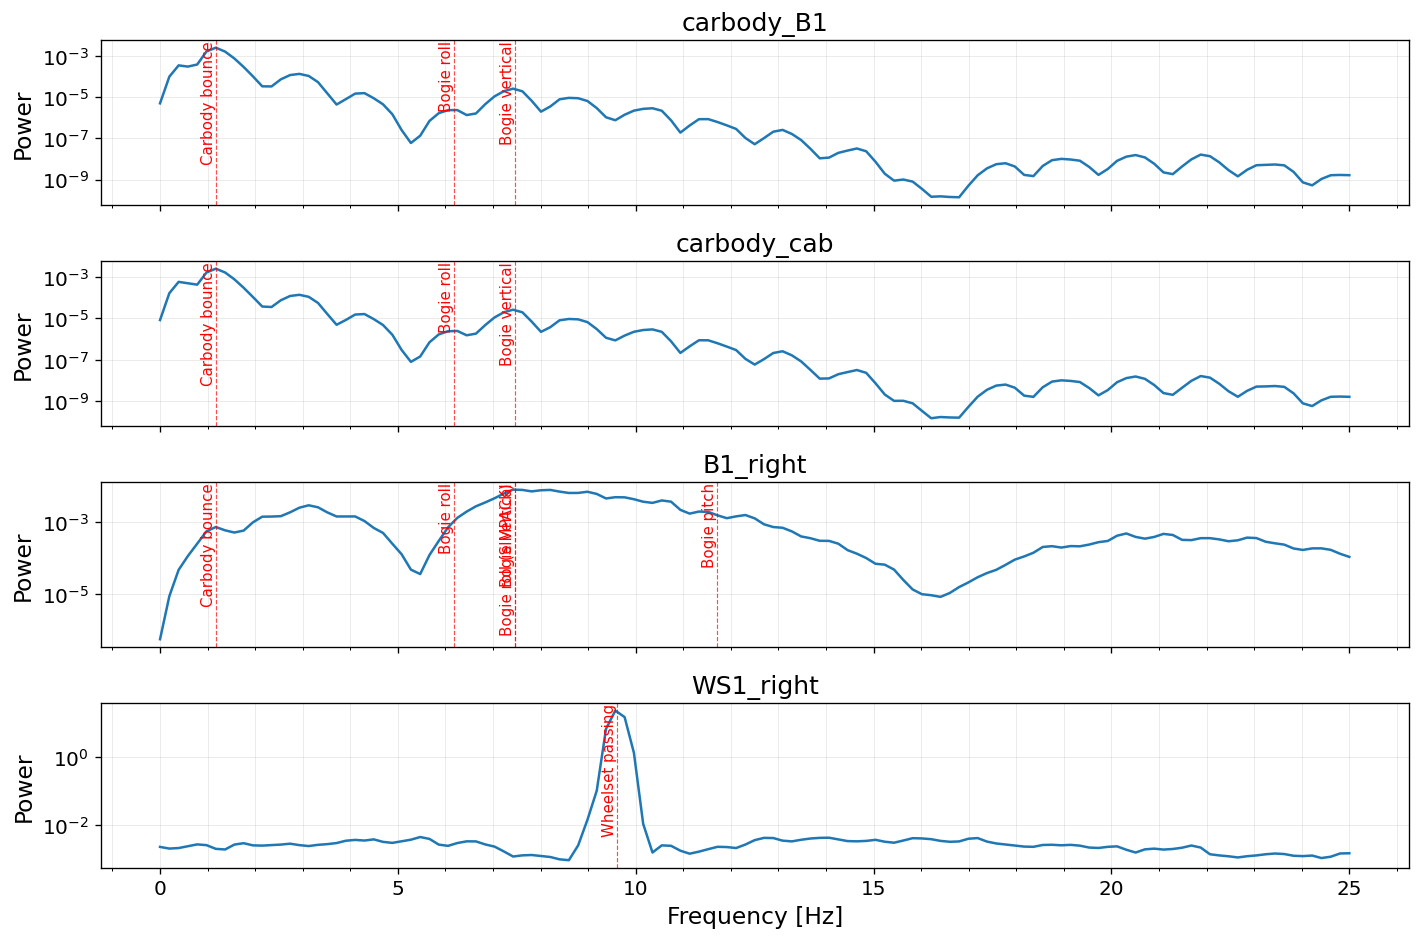

'\nNOTES\n\nCarbody and bogie peaks align with calculated resonant frequencies of the vehicle\n\nCB modes:\n    - vertical: 1.17 Hz\nBogie modes:\n    - vertical: 7.46 Hz\n    - roll: 6.17 Hz\n    - pitch: 11.71 Hz\nCoupled modes:\n    - vertical high freq.: 7.47 Hz\n    - vertical low freq.: 1.07 Hz Hz\nWheelset:\n    - wheel passing frequency: 9.61 Hz\n'

In [30]:
# A mean spectrum shows dominant frequencies more clearly

fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 8), sharex=True)

mode_annotations = {
    sensor_names[0]: [(1.17, "Carbody bounce"),(6.17, "Bogie roll"), (7.46, "Bogie vertical")],
    sensor_names[1]: [(1.17, "Carbody bounce"),(6.17, "Bogie roll"), (7.46, "Bogie vertical")],
    sensor_names[2]: [(1.17, "Carbody bounce"),(6.17, "Bogie roll"), (7.46, "Bogie vertical"), (7.46, "Bogie roll (SIMPACK)"), (11.71, "Bogie pitch")],
    sensor_names[3]: [(9.61, "Wheelset passing")],
}  # see notes

for ax, sensor_name in zip(axes, sensor_names):
    stft_data = stft_results[sensor_name]
    Zxx = stft_data["Zxx"]
    f = stft_data["f"]

    mean_spectrum = np.mean(np.abs(Zxx)**2, axis=1)

    ax.semilogy(f, mean_spectrum)
    ax.set_ylabel("Power")
    ax.set_title(sensor_name)
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.grid(True, which="both", linewidth=0.3, alpha=0.5)

    # Plot and annotate modes for this subplot
    for freq, label in mode_annotations.get(sensor_name, []):
        ax.axvline(freq, color="red", linestyle="--", linewidth=0.7, alpha=0.7)

        ax.text(
            freq, ax.get_ylim()[1],
            label,
            rotation=90,
            verticalalignment="top",
            horizontalalignment="right",
            fontsize=9,
            color="red",
        )

axes[-1].set_xlabel("Frequency [Hz]")

fig.tight_layout()
plt.show()

"""
NOTES

Carbody and bogie peaks align with calculated resonant frequencies of the vehicle

CB modes:
    - vertical: 1.17 Hz
Bogie modes:
    - vertical: 7.46 Hz
    - roll: 6.17 Hz
    - pitch: 11.71 Hz
Coupled modes:
    - vertical high freq.: 7.47 Hz
    - vertical low freq.: 1.07 Hz Hz
Wheelset:
    - wheel passing frequency: 9.61 Hz
"""


### 3. Extract peaks and inform the system about physics

In [31]:
# Inputs
peaks_all = {}

for sensor in range(4):

    stft_magnitude = stft_results[sensor_names[sensor]]["stft_magnitude"]
    time_frames = stft_results[sensor_names[sensor]]["t"]
    peaks_per_frame = 5  # Number of peaks to extract per STFT frame

    peaks, band_masks, band_weights = sr.peaks(stft_magnitude, time_frames, peaks_per_frame, freqs)

    peaks_all[sensor_names[sensor]] = peaks


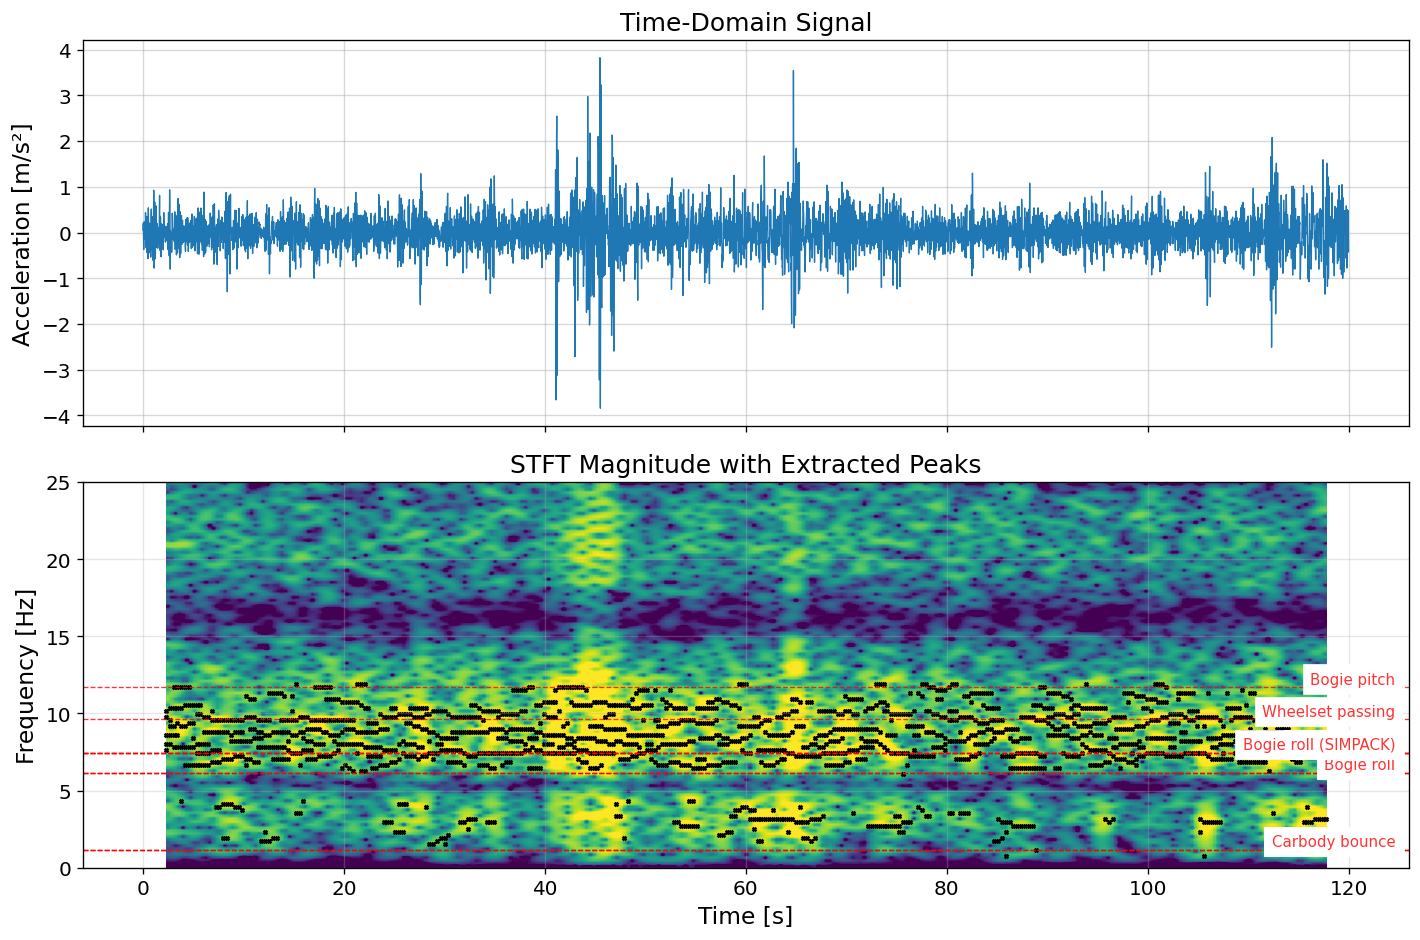

In [32]:
# Visualizing full spectra for bogie (sensor 2)
sensor = 2

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

signal_array, time, distance = sensor_data_detrended[sensor_names[sensor]]

ax1.plot(time, signal_array, linewidth=0.8)
ax1.set_ylabel("Acceleration [m/s²]")
ax1.set_title("Time-Domain Signal")
ax1.grid(True, alpha=0.5)

peak_freqs = np.array([p[0] for p in peaks_all[sensor_names[sensor]]])
peak_times = np.array([p[1] for p in peaks_all[sensor_names[sensor]]])
peak_mags = np.array([p[2] for p in peaks_all[sensor_names[sensor]]])

mag_db = 10 * np.log10(stft_results[sensor_names[sensor]]["stft_magnitude"] + 1e-12)  # prevent taking the log of zero (infinite magnitude for lg(0))
vmin = np.percentile(mag_db, 5)
vmax = np.percentile(mag_db, 95)
im = ax2.imshow(
    mag_db,
    aspect="auto",
    origin="lower",
    extent=[t[0], t[-1], freqs[0], freqs[-1]],
    vmin=vmin,
    vmax=vmax,
    cmap="viridis"
)



ax2.scatter(peak_times, peak_freqs, marker='x', s=5, color='black')

# Horizontal lines for resonant modes
for i in range(4):
    for freq, label in mode_annotations.get(sensor_names[i], []):
        ax2.axhline(freq, color="red", linestyle="--", linewidth=0.8, alpha=0.8)

        # label on the right side of the spectrogram
        ax2.text(
            0.99, freq,
            label,
            transform=ax2.get_yaxis_transform(),  # x in axes coords, y in data coords
            ha="right",
            va="bottom",
            fontsize=9,
            color="red",
            backgroundcolor="white",
            alpha=0.8,
        )

ax2.set_xlabel("Time [s]")
ax2.set_ylabel("Frequency [Hz]")
ax2.set_title("STFT Magnitude with Extracted Peaks")
ax2.grid(True, alpha=0.3)

fig.tight_layout()
plt.show()

In [33]:
"""
There is a cluster of suddenly appearing peaks for e.g. the bogie acceleration at 3 Hz which cannot be explained with the vehicle parameters.
Let's analyze the track irregularity input in that range.
"""

sub_peaks = [p for p in peaks_all[sensor_names[sensor]] if 60 <= p[1] <= 65]
sub_peaks_2 = [p for p in peaks_all[sensor_names[sensor]] if 40 <= p[1] <= 45]

freqs_1 = np.array([p[0] for p in sub_peaks])
freqs_2 = np.array([p[0] for p in sub_peaks_2])

# count occurrences
unique_freqs_1, counts = np.unique(freqs_1, return_counts=True)
unique_freqs_2, counts_2 = np.unique(freqs_2, return_counts=True)

print(unique_freqs_1)
print(counts)

[ 1.7578125  2.34375    2.5390625  2.9296875  3.125      3.7109375
  3.90625    6.640625   6.8359375  7.03125    7.2265625  7.421875
  7.6171875  8.3984375  8.59375    8.7890625  9.1796875  9.375
  9.5703125  9.765625   9.9609375 10.15625   10.9375    11.9140625]
[ 2  1  1  1 12  3  1  3  2  2  1  4  8  1  7  2  5  1  2  4  2  2  2  1]


In [35]:
filename = r"C:\Users\prife\OneDrive - KTH\KTH\04 Research\01 Conferences\2026\Railways\01 Simulations\database\track_excitation\trackirreg.txt"

data_rows = []
with open(filename, "r") as f:
    for line in f:
        line = line.strip()
        if not line:
            continue
        if line.startswith(("!", "header.", "+")) is False:
            continue
        # data rows start with + or - or digit
        if line[0] in "+-0123456789":
            data_rows.append(line)

data = np.loadtxt(data_rows)

s     = data[:, 0]  # distance channel
u_z   = data[:, 2]  # vertical excitation

s_min_1 = 16610.0
s_max_1 = 16750.0
s_min_2 = 17160.0
s_max_2 = 17305.0

mask_1 = (s >= s_min_1) & (s <= s_max_1)
mask_2 = (s >= s_min_2) & (s <= s_max_2)

s_c_1     = s[mask_1]
u_z_c_1   = u_z[mask_1]
s_c_2     = s[mask_2]
u_z_c_2   = u_z[mask_2]

signal_vertical_1 = u_z_c_1.copy()
signal_vertical_1 = signal_vertical_1 / 1000  # mm -> m
signal_vertical_2 = u_z_c_2.copy()
signal_vertical_2 = signal_vertical_2 / 1000  # mm -> m

# remove last value to reduce leakage
signal_vertical_1 = signal_vertical_1[:-1]
signal_vertical_2 = signal_vertical_2[:-1]

# spatial sampling
dx = 0.16  # meters
fs_space = 1.0 / dx  # samples per meter

window_length_m = 100.0
window_length_samples = int(window_length_m / dx)

overlap = 0.25
hop = int(window_length_samples * (1 - overlap))

window = get_window("hann", window_length_samples, fftbins=True)

spectra_v_1 = []
spectra_v_2 = []

for start in range(0, len(signal_vertical_1) - window_length_samples + 1, hop):
    segment_v = signal_vertical_1[start:start + window_length_samples]

    segment_v = segment_v - np.mean(segment_v)  # remove DC
    segment_v = segment_v * window

    fft_vals_v = np.fft.rfft(segment_v)
    amp_v = np.abs(fft_vals_v) * 2 / np.sum(window)   # amplitude scaling

    spectra_v_1.append(amp_v)

for start in range(0, len(signal_vertical_2) - window_length_samples + 1, hop):
    segment_v = signal_vertical_2[start:start + window_length_samples]

    segment_v = segment_v - np.mean(segment_v)  # remove DC
    segment_v = segment_v * window

    fft_vals_v = np.fft.rfft(segment_v)
    amp_v = np.abs(fft_vals_v) * 2 / np.sum(window)   # amplitude scaling

    spectra_v_2.append(amp_v)

spectra_v_1 = np.array(spectra_v_1)
spectra_v_2 = np.array(spectra_v_2)

amp_avg_vertical_1 = np.mean(spectra_v_1, axis=0)
amp_avg_vertical_2 = np.mean(spectra_v_2, axis=0)

# spatial frequency axis (1/m)
freq_space = np.fft.rfftfreq(window_length_samples, d=dx)

v = 100.0 / 3.6  # m/s
freq_time = freq_space * v  # Hz

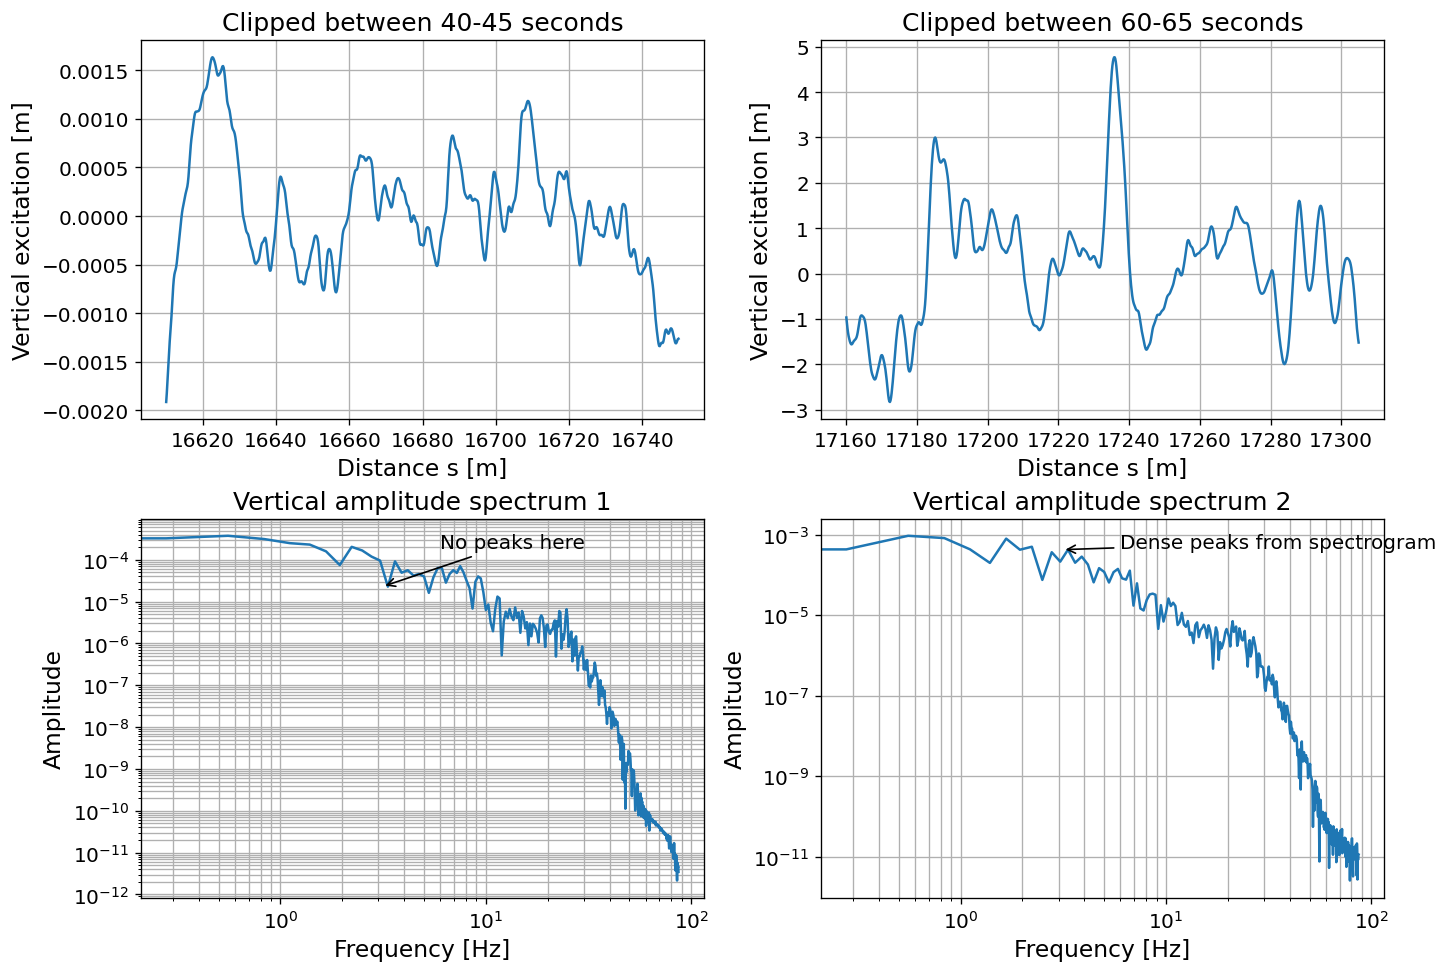

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(12, 8), constrained_layout=True)

axs[0, 0].plot(s_c_1, u_z_c_1 / 1000)  # mm -> m
axs[0, 0].set_xlabel("Distance s [m]")
axs[0, 0].set_ylabel("Vertical excitation [m]")
axs[0, 0].set_title("Clipped between 40-45 seconds")
axs[0, 0].grid(True, which="both")

axs[0, 1].plot(s_c_2, u_z_c_2)
axs[0, 1].set_xlabel("Distance s [m]")
axs[0, 1].set_ylabel("Vertical excitation [m]")
axs[0, 1].set_title("Clipped between 60-65 seconds")
axs[0, 1].grid(True, which="both")

axs[1, 0].loglog(freq_time, amp_avg_vertical_1)
axs[1, 0].set_xlabel("Frequency [Hz]")
axs[1, 0].set_ylabel("Amplitude")
axs[1, 0].set_title("Vertical amplitude spectrum 1")
axs[1, 0].grid(True, which="both")

axs[1, 0].annotate(
    "No peaks here",
    xy=(3.125, amp_avg_vertical_1[np.searchsorted(freq_time, 3.125)]),
    xytext=(6, np.max(amp_avg_vertical_1) * 0.5),
    arrowprops=dict(arrowstyle="->"),
)

axs[1, 1].loglog(freq_time, amp_avg_vertical_2)
axs[1, 1].set_xlabel("Frequency [Hz]")
axs[1, 1].set_ylabel("Amplitude")
axs[1, 1].set_title("Vertical amplitude spectrum 2")
axs[1, 1].grid(True, which="both")

axs[1, 1].annotate(
    "Dense peaks from spectrogram",
    xy=(3.125, amp_avg_vertical_2[np.searchsorted(freq_time, 3.125)]),
    xytext=(6, np.max(amp_avg_vertical_2) * 0.5),
    arrowprops=dict(arrowstyle="->"),
)

plt.show()

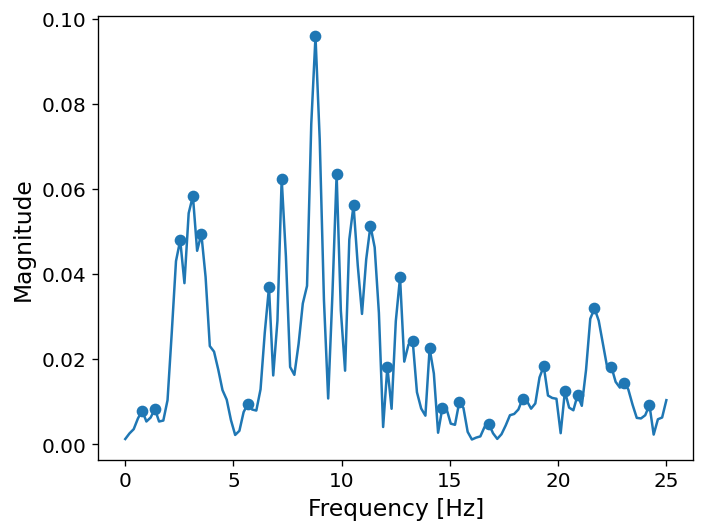

In [38]:
# Single frame
frame_idx = 80
frame = stft_results[sensor_names[2]]["stft_magnitude"][:, frame_idx]

window = 3
half_window = window // 2
local_max = np.zeros(len(frame), dtype=bool)

for i in range(half_window, len(frame) - half_window):
    if frame[i] == np.max(frame[i-half_window:i+half_window+1]) and frame[i] > 0:
        local_max[i] = True

fig, ax = plt.subplots()

ax.plot(freqs, frame)
ax.scatter(freqs[local_max], frame[local_max])

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude")

plt.show()

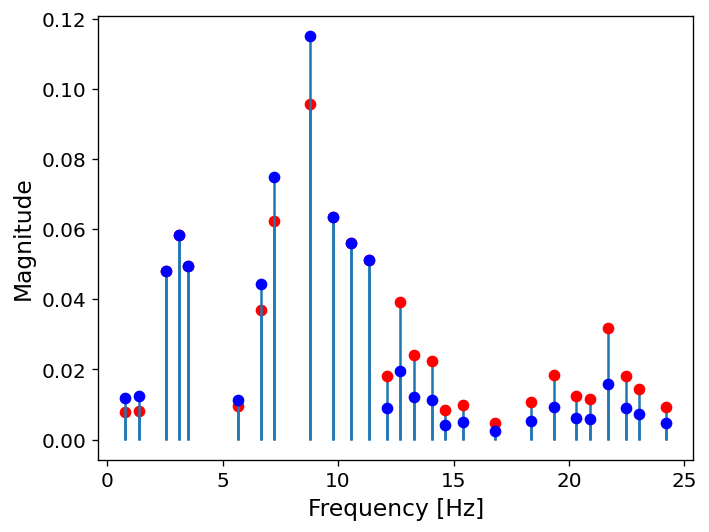

In [39]:
# Effect of frequency band weighing (to verify code works)

peak_indices = np.where(local_max)[0]
peak_magnitudes = frame[peak_indices]

weights = np.ones(len(peak_indices))
for band_name, band_mask in band_masks.items():
    weights[band_mask[peak_indices]] = band_weights[band_name]

weighted_magnitudes = peak_magnitudes * weights

fig, ax = plt.subplots()

ax.stem(freqs[peak_indices], peak_magnitudes, basefmt=" ", markerfmt="red")
ax.stem(freqs[peak_indices], weighted_magnitudes, basefmt=" ", markerfmt="blue")

ax.set_xlabel("Frequency [Hz]")
ax.set_ylabel("Magnitude")

plt.show()

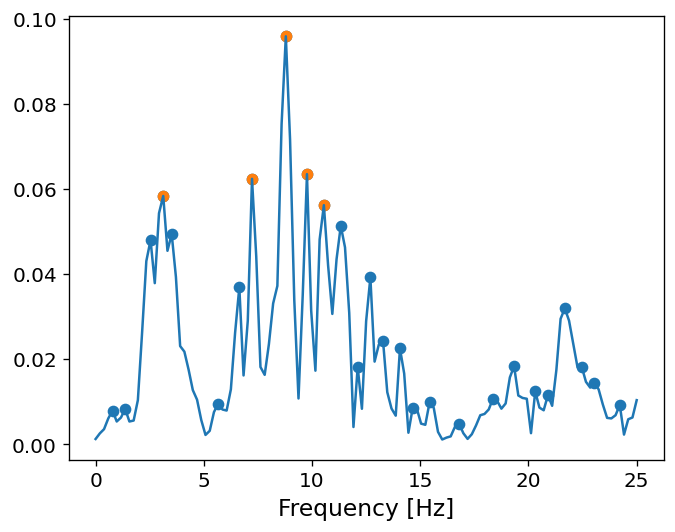

In [40]:
# Top 5 peak selection

top_indices = np.argsort(-weighted_magnitudes)[:peaks_per_frame]

fig, ax = plt.subplots()

ax.plot(freqs, frame)
ax.scatter(freqs[peak_indices], frame[peak_indices])
ax.scatter(freqs[peak_indices[top_indices]],
           frame[peak_indices[top_indices]])

ax.set_xlabel("Frequency [Hz]")

plt.show()

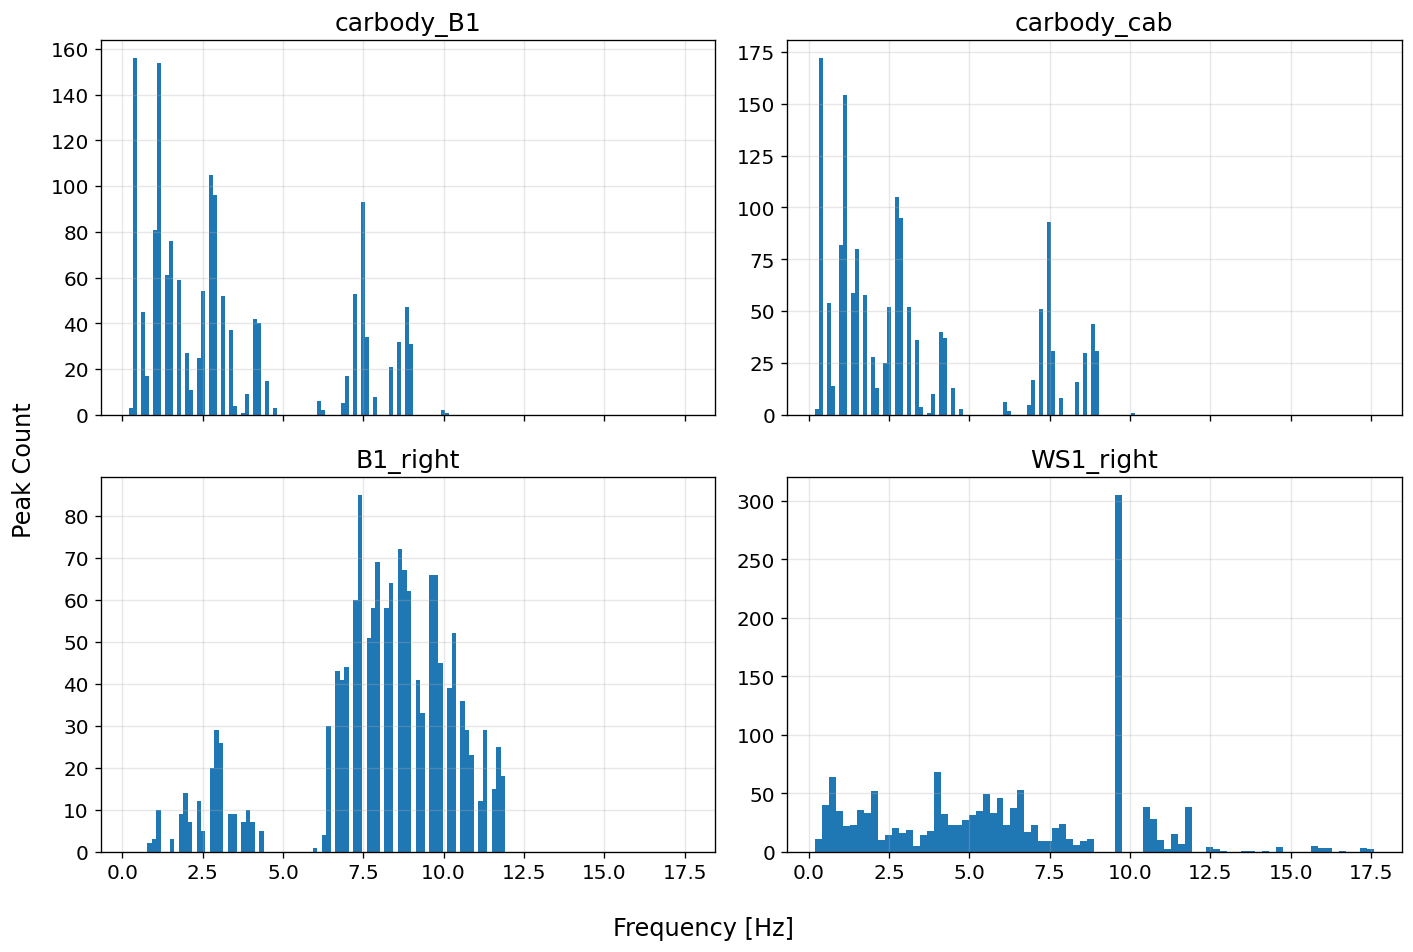

In [41]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)
axes = axes.ravel()  # flatten to 1D for easy indexing

for sensor in range(4):
    ax = axes[sensor]

    stft_magnitude = stft_results[sensor_names[sensor]]["stft_magnitude"]
    time_frames = stft_results[sensor_names[sensor]]["t"]

    peak_freqs = np.array([p[0] for p in peaks_all[sensor_names[sensor]]])

    ax.hist(peak_freqs, bins=80)
    ax.set_title(sensor_names[sensor])
    ax.grid(True, alpha=0.3)

# shared labels for the whole figure
fig.supxlabel("Frequency [Hz]")
fig.supylabel("Peak Count")

fig.tight_layout()
plt.show()

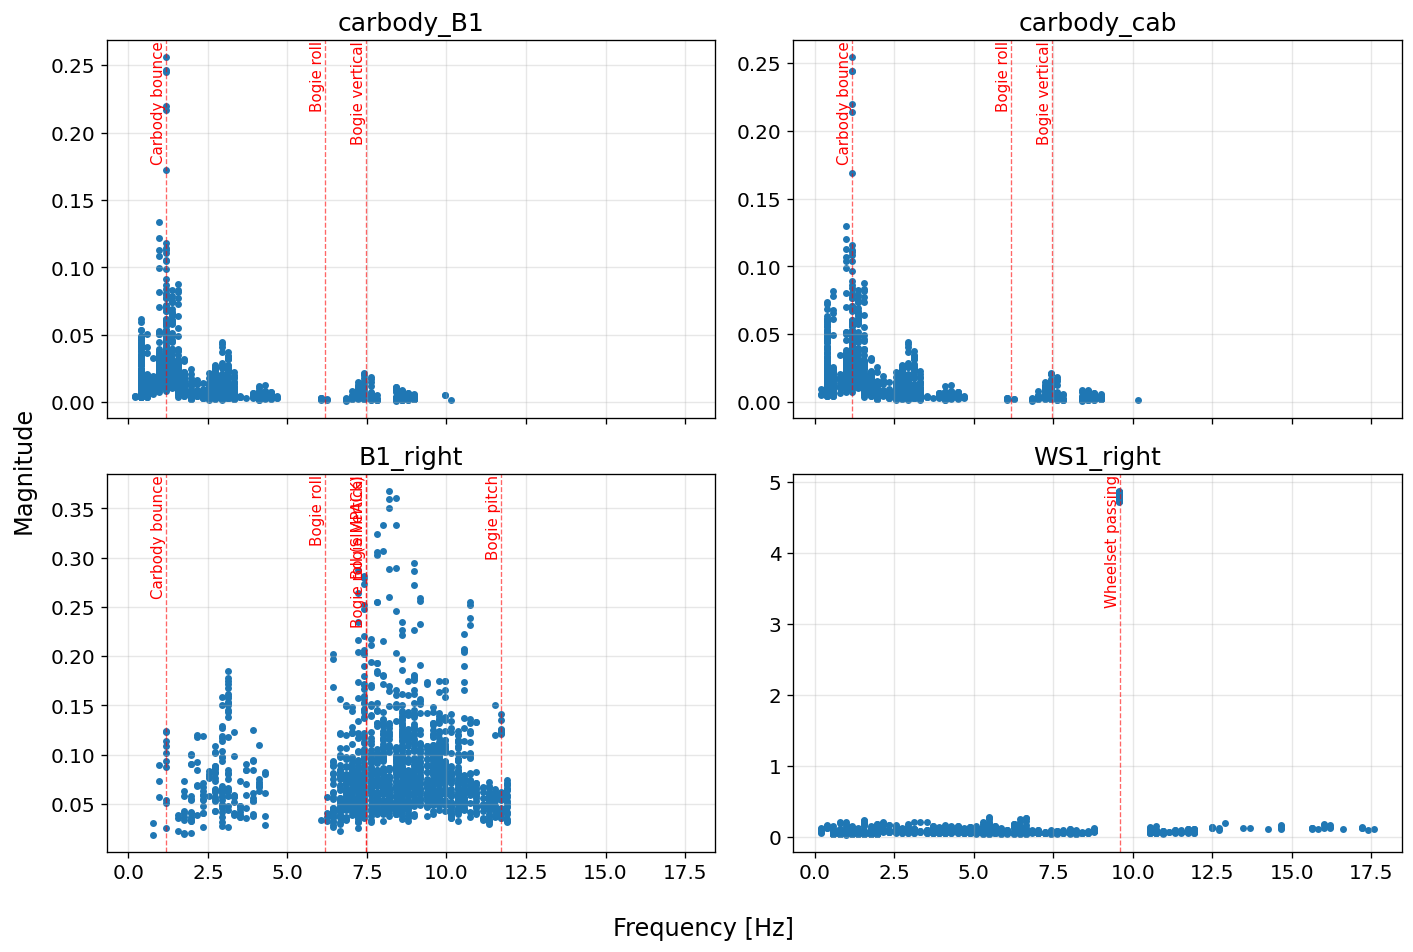

'\nNOTE\n\nSame frequencies show up many times with different magnitudes. Magnitude-independency is important.\n'

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8), sharex=True, sharey=False)
axes = axes.ravel()

for sensor in range(4):
    ax = axes[sensor]

    stft_magnitude = stft_results[sensor_names[sensor]]["stft_magnitude"]
    time_frames = stft_results[sensor_names[sensor]]["t"]

    peak_freqs = np.array([p[0] for p in peaks_all[sensor_names[sensor]]])
    peak_mags  = np.array([p[2] for p in peaks_all[sensor_names[sensor]]])

    ax.scatter(peak_freqs, peak_mags, s=10)
    ax.set_title(sensor_names[sensor])
    ax.grid(True, alpha=0.3)

    for freq, label in mode_annotations.get(sensor_names[sensor], []):
        ax.axvline(freq, color="red", linestyle="--", linewidth=0.8, alpha=0.6)
        ax.text(
            freq, ax.get_ylim()[1],
            label,
            rotation=90,
            verticalalignment="top",
            horizontalalignment="right",
            fontsize=9,
            color="red",
        )

fig.supxlabel("Frequency [Hz]")
fig.supylabel("Magnitude")

fig.tight_layout()
plt.show()

"""
NOTE

Same frequencies show up many times with different magnitudes. Magnitude-independency is important.
"""

### 4. Fingerprinting

In [43]:
# Inputs
time_window_sec = 2.0  # Time window forward of anchor peak for finding targets (seconds)
freq_quantization_hz = 1.0  # Frequency quantization bin size (Hz) so bin number corresponds to frequency
time_quantization_sec = 0.1  # Time quantization bin size (seconds): 100 ms

peaks = peaks_all[sensor_names[2]]

fingerprints, stats = sr.fingerprinting(time_window_sec, freq_quantization_hz, time_quantization_sec, peaks)

"""
NOTES

Quantization: grouping time or frequencies into discrete set of levels. Tradeoff between fine and coearse-- too fine: lose robustness to noise, too coarse: lose discriminative power
"""

Number of time bins: 20
Number of frequency bins: 25
Generated 658 unique fingerprints from 1525 peaks.


'\nNOTES\n\nQuantization: grouping time or frequencies into discrete set of levels. Tradeoff between fine and coearse-- too fine: lose robustness to noise, too coarse: lose discriminative power\n'

In [44]:
print(f"  Total hashes: {stats['total_hashes']}")
print(f"  Unique hashes: {stats['unique_hashes']}")
print(f"  Avg occurrences per hash: {stats['avg_occurrences']:.2f}")
print(f"  Max occurrences: {stats['max_occurrences']}")

for i, hash_tuple in enumerate(list(fingerprints.keys())[:5]):
    times = fingerprints[hash_tuple]
    f1, f2, t = hash_tuple
    display_str = f"F({f1},{f2})_Δt({t})"
    print(f"  {i + 1}: {display_str}, appears at {len(times)} anchor times")


"""
NOTES

The dominant frequency is in 8Hz (for bogie frame) that occurs consecutively a lot of times within 0.3-1.8 seconds

"""

  Total hashes: 37750
  Unique hashes: 658
  Avg occurrences per hash: 57.37
  Max occurrences: 572
  1: F(8,8)_Δt(3), appears at 572 anchor times
  2: F(8,8)_Δt(7), appears at 541 anchor times
  3: F(8,8)_Δt(11), appears at 524 anchor times
  4: F(8,8)_Δt(15), appears at 514 anchor times
  5: F(8,8)_Δt(18), appears at 276 anchor times


'\nNOTES\n\nThe dominant frequency is in 8Hz (for bogie frame) that occurs consecutively a lot of times within 0.3-1.8 seconds\n\n'

### 5. Save fingerprints to database

In [45]:
# Separate db per sensor? Makes more sense --> dictionary, no combination of sensor fingerprints
# Real scenario, so we re-process the data
# STFT inputs

# Initialize database
db = {}
scenario = "S7_IRREG1_K1"
sensor_name = "B1_right"
acceleration, time, dist = sensor_data[sensor_name]

window_samples = int(window_length * fs)
stride_samples = int(window_samples * (1 - overlap))

# Segmentate the same way as for the STFT - 4 second windows, 0.4 second overlap sliding window
segments = []
segment_idx = 0

for start_idx in range(0, len(acceleration) - window_samples, stride_samples):
    end_idx = start_idx + window_samples
    segment_signal = acceleration[start_idx:end_idx].copy()
    segment_time = time[start_idx:end_idx].copy()
    segments.append((segment_signal, segment_time, segment_idx))

    segment_idx += 1

In [ ]:
# Calculate fingerprints per segment and add to database
for seg_idx, (seg_signal, seg_time, _) in enumerate(segments[:10]):
    stft_magnitude, peaks, time_frames = sr.process_signal(seg_signal)
    fingerprints, _ = sr.fingerprinting(time_window_sec, freq_quantization_hz, time_quantization_sec, peaks)

    for hash_tuple, anchor_times in fingerprints.items():
        for anchor_time in anchor_times:

            hash_tuple,
            scenario,
            seg_idx,
            sensor_name,
            anchor_time,
            seg_time


    def add_fingerprint(
        self,
        hash_tuple: Tuple[int, int, int],
        scenario_name: str,
        segment_index: int,
        sensor_name: str,
        anchor_time_sec: float,
        frame_time_sec: float,
    ) -> None:
        """Add a single fingerprint to the database.

        Args:
            hash_tuple: Quantized fingerprint hash
            scenario_name: Name of simulation scenario (e.g., "S1_ERRI1_K1")
            segment_index: Index of segment within simulation
            sensor_name: Sensor location (e.g., "carbody", "bogie", "axlebox")
            anchor_time_sec: Time of anchor peak within segment
            frame_time_sec: Absolute time in simulation
        """
        self.scenario_names.add(scenario_name)
        self.sensor_names.add(sensor_name)

        record = (scenario_name, segment_index, sensor_name, anchor_time_sec, frame_time_sec)

        if self.combine_sensors:
            self.db[hash_tuple].append(record)
        else:
            if sensor_name not in self.db:
                self.db[sensor_name] = defaultdict(list)
            self.db[sensor_name][hash_tuple].append(record)

